In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train = "/content/drive/MyDrive/KLTN2023/DataKLTN2023/data_text/train.csv"
val = "/content/drive/MyDrive/KLTN2023/DataKLTN2023/data_text/val.csv"
test = "/content/drive/MyDrive/KLTN2023/DataKLTN2023/data_text/test.csv"

In [ ]:
train_data= pd.read_csv(train)
train_data= train_data.dropna()
test_data= pd.read_csv(test)
test_data= test_data.dropna()
val_data= pd.read_csv(val)
val_data= val_data.dropna()

In [ ]:
# tính số lượng nhãn
train_data['label'].value_counts()

normal          193
violent         163
offensive       128
horrible        121
pornographic     47
Name: label, dtype: int64

In [ ]:
val_data['label'].value_counts()

normal          23
violent         19
offensive       17
horrible        14
pornographic     2
Name: label, dtype: int64

In [ ]:
test_data['label'].value_counts()

violent         26
normal          22
offensive       13
horrible        10
pornographic     7
Name: label, dtype: int64

Load bộ word-embedding

In [ ]:
EMBEDDING = '/content/drive/MyDrive/word2vec_vi_words_100dims.txt'
EMBEDING_DIM = 100
MAX_FEATURE = 10000
word_dict = []
embeddings_index = {}
embedding_dim = EMBEDING_DIM
max_feature = MAX_FEATURE
f = open(EMBEDDING)
for line in f:
  values = line.split(' ')
  word = values[0]
  word_dict.append(word)
  try:
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  except Exception as e:
    pass
f.close()
print('Embedding data loaded')

Embedding data loaded


In [ ]:
words = word_dict
num_words = len(words)
# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0
# Dictionary label:index pair
idx2word = {i: w for w, i in word_to_index.items()}

In [ ]:
embedding_matrix = np.zeros((num_words, embedding_dim))
# for each word in out tokenizer, try to find that work in our w2v model
for word, i in word_to_index.items():
  if i > max_feature:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # add that words vector to the matrix
    embedding_matrix[i] = embedding_vector
  else:
    # doesn't exist, assign a random vector
    embedding_matrix[i] = np.random.randn(embedding_dim)

In [ ]:
!pip install vncorenlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=ed957236ff6c9f95e19035f23a3126582900ef8117704eaa8896008ce6991268
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2024-01-04 07:28:20--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.1s    

2024-01-04 07:28:20 (201 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2024-01-04 07:28:20--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

In [ ]:
from vncorenlp import VnCoreNLP
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar",
annotators="wseg", max_heap_size='-Xmx500m')
def custom_tokenizer(text_data, tokenizer=True):
  if tokenizer:
    return " ".join(vncorenlp.tokenize(str(text_data))[0])
  return text_data

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
MAX_LEN = 22
NUM_LABEL = 5
TOKENIZER = True
def encoding(X, y):
  sentences = []
  for t in X:
    sentences.append(custom_tokenizer(t, tokenizer=TOKENIZER))
  X = []
  for s in sentences:
    sent = []
    for w in s.split():
      try:
        w = w.lower()
        sent.append(word_to_index[w])
      except:
        sent.append(word_to_index["UNK"])
    X.append(sent)
  X = pad_sequences(maxlen = MAX_LEN, sequences = X,
                    padding = "post", value = word_to_index["PAD"])
  #y = to_categorical(y, num_classes=NUM_LABEL)
  return (X,y)

In [ ]:
class_names = ['horrible', 'normal', 'offensive', 'pornographic', 'violent']
class_ids_for_name = dict((name, idx) for idx, name in enumerate(class_names))
def encode_label(data):
  for name in class_names:
    data['label'] = data['label'].replace(name, class_ids_for_name[name])
  return data
train_data = encode_label(train_data)
val_data = encode_label(val_data)
test_data = encode_label(test_data)

In [ ]:
y_test_encoded = test_data['label']
y_test = y_test_encoded.values

In [ ]:
X_train_encoded, y_train_encoded = encoding(train_data['text'],train_data['label'])
X_dev_encoded, y_dev_encoded = encoding(val_data['text'],val_data['label'])
X_test_encoded, y_test_encoded = encoding(test_data['text'],test_data['label'])

In [ ]:
X_train_encoded

array([[  679,    22,     7, ...,     0,     0,     0],
       [   16,   484,     8, ...,     0,     0,     0],
       [ 1980,     9,   103, ...,     0,     0,     0],
       ...,
       [ 2703,   239,    43, ...,   230,   577,  1720],
       [   16,    44, 15343, ...,     0,     0,     0],
       [    5,  1459,    43, ...,     0,     0,     0]], dtype=int32)

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import  TimeDistributed, Dense, Input, LSTM, Embedding, Bidirectional

In [ ]:
model_2LSTM = Sequential()
model_2LSTM.add(Input(shape=(MAX_LEN, ), dtype="float64"))
model_2LSTM.add(Embedding(input_dim=num_words,output_dim=embedding_dim,embeddings_initializer= Constant(embedding_matrix),
                    input_length=MAX_LEN, trainable=False))
model_2LSTM.add(Bidirectional(LSTM(200, return_sequences=True)))
model_2LSTM.add(Bidirectional(LSTM(200, return_sequences=False)))
model_2LSTM.add(Dense(5, activation='softmax'))

In [ ]:
optimizer = Adam(learning_rate = 0.001)
loss = CategoricalCrossentropy()
callback = EarlyStopping(monitor="val_loss", patience=3)
model_2LSTM.compile(optimizer = optimizer, loss = loss, metrics = ['Accuracy'])
history = model_2LSTM.fit(X_train_encoded, y_train_encoded, batch_size = 16,
                    epochs = 50,
                    validation_data= (X_dev_encoded, y_dev_encoded),
                    callbacks = callback)

Epoch 1/50
41/41 [==============================] - 19s 259ms/step - loss: 1.4372 - Accuracy: 0.3850 - val_loss: 1.3804 - val_Accuracy: 0.4267
Epoch 2/50
41/41 [==============================] - 7s 172ms/step - loss: 1.2550 - Accuracy: 0.5123 - val_loss: 1.1473 - val_Accuracy: 0.5733
Epoch 3/50
41/41 [==============================] - 8s 203ms/step - loss: 1.1216 - Accuracy: 0.5491 - val_loss: 1.1000 - val_Accuracy: 0.5467
Epoch 4/50
41/41 [==============================] - 6s 158ms/step - loss: 1.0852 - Accuracy: 0.5629 - val_loss: 1.3867 - val_Accuracy: 0.5867
Epoch 5/50
41/41 [==============================] - 11s 275ms/step - loss: 1.0878 - Accuracy: 0.5644 - val_loss: 0.9945 - val_Accuracy: 0.5733
Epoch 6/50
41/41 [==============================] - 8s 187ms/step - loss: 0.9696 - Accuracy: 0.6242 - val_loss: 0.9296 - val_Accuracy: 0.6400
Epoch 7/50
41/41 [==============================] - 7s 174ms/step - loss: 0.9282 - Accuracy: 0.6365 - val_loss: 0.9251 - val_Accuracy: 0.6533
Epoc

In [ ]:
y_pred = model_2LSTM.predict(X_test_encoded)
y_pred = np.argmax(y_pred, axis=-1)

3/3 [==============================] - 2s 50ms/step


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_test.flatten(), y_pred.flatten()))

              precision    recall  f1-score   support

           0       0.40      0.60      0.48        10
           1       0.47      0.73      0.57        22
           2       0.40      0.46      0.43        13
           3       0.00      0.00      0.00         7
           4       0.86      0.46      0.60        26

    accuracy                           0.51        78
   macro avg       0.43      0.45      0.42        78
weighted avg       0.54      0.51      0.49        78



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


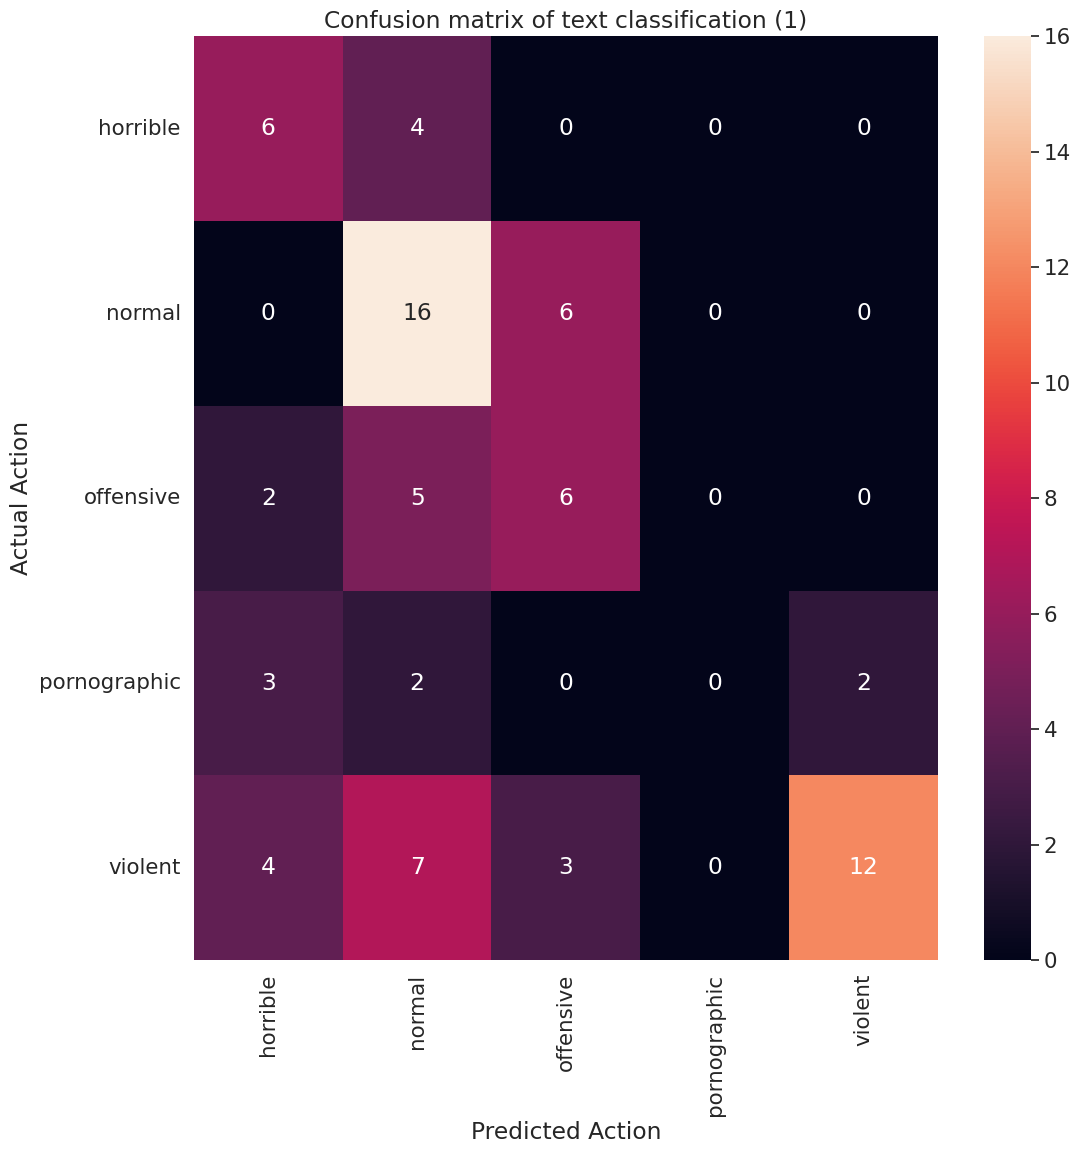

In [ ]:
import seaborn as sns
import tensorflow as tf
def plot_confusion_matrix(actual, predicted, labels):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of text classification (1)')
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
plot_confusion_matrix(y_test, y_pred,class_names)

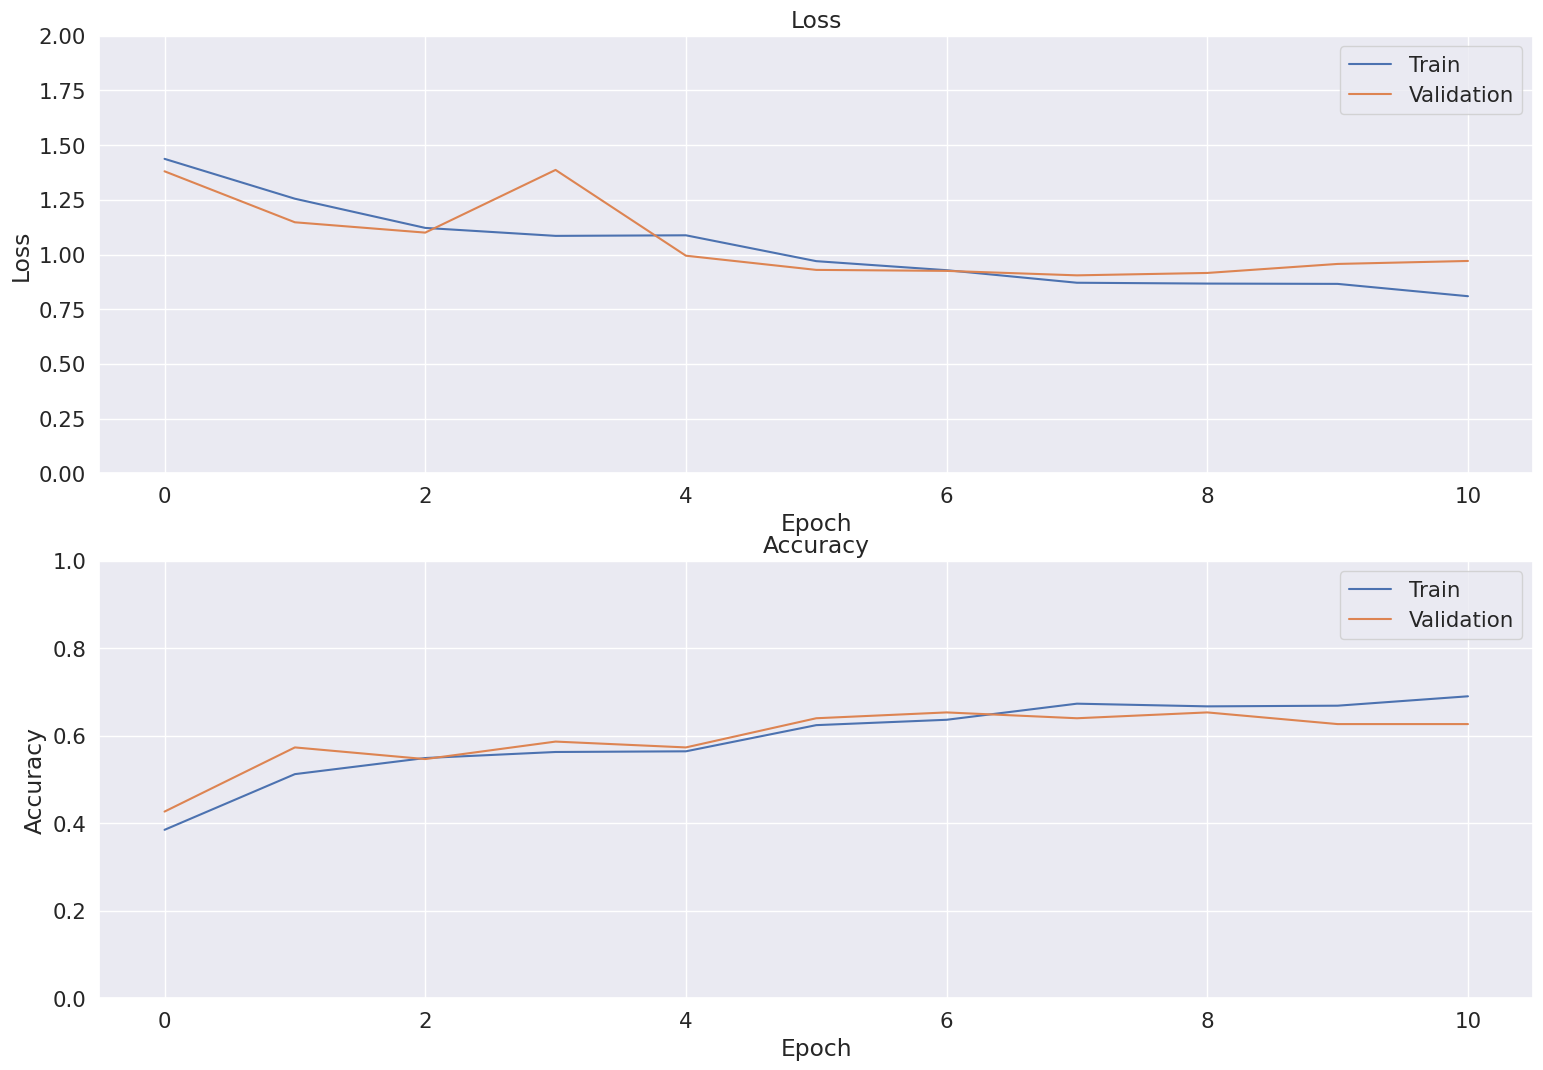

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 12.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['Accuracy'],  label = 'train')
  ax2.plot(history.history['val_Accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)